# Text Classification with BERT

![bert](https://res.cloudinary.com/practicaldev/image/fetch/s--ozy733MJ--/c_imagga_scale,f_auto,fl_progressive,h_420,q_auto,w_1000/https://dev-to-uploads.s3.amazonaws.com/i/q5e65ugnue96bir3usyk.png)

BERT (Bidirectional Encoder Representations from Transformers) is a NLP model developed by Google in 2018. It is a model that is already pre-trained on a 2,5000M (+- 170 GB) words corpus from Wikipedia.

To accomplish a particular NLP task, the pre-trained BERT model is used as a base and refined by adding an additional layer; the model can then be trained on a labeled dataset dedicated to the NLP task to be performed. This is the very principle of transfer learning. It is important to note that BERT is a very large model with 12 layers, 12 attention heads and 110 million parameters (BERT base).

The BERT model is able to do :

*   Translation
*   Text generation
*   Classification
*   Question-answering
*   ...

### Why BERT?

Using the General Language Understanding Evaluation ([GLUE](https://gluebenchmark.com/)) benchmark [leaderboard](https://gluebenchmark.com/leaderboard) , its easy to realize that many models on the list are all forks of BERT.

## Let's go !
To use BERT you need to have either pytorch or tensorflow installed in your environment. It is also preferable to have access to a GPU on your computer. If you don't have a GPU you can use [Google Colab](https://colab.research.google.com/).

Next, let’s install the transformers package from Hugging Face. This package is an interface between BERT and pytorch and/or tensorflow.




In [1]:
!pip install transformers

## Load the Data

For this project we will use the data from Odile. Odile is a bot that tries to answer general questions on a few BeCode Discord servers. The sentences all come from conversations between learners and Odile on Discord.

You'll find the data in `./dataset/odile_data.csv`. You can import them in a dataframe and display it.

**Tip:** if you are using Google colab you can import the CSV in your google drive and connect your notebook to your Google drive (check on Google how to do that !)





In [1]:
import pandas as pd
import random

df = pd.read_csv("./dataset/odile_data.csv")

# If colab
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv("drive/MyDrive/odile_data.csv") 

#df.head()

## Explore the data

It's time to take a quick look at our data.

As you see the questions from the learners are classified as intents (i.e. the goal the user has in mind when typing in a question or comment)

**Exercise:** Use your data exploration and visualization skills to answer the the following questions:

*   How many observations does the dataset contain?
*   How many different labels does the dataset contain?
*   Which labels contain the most observations?
*   Which labels contain the fewest observations?

In [4]:
# Display the columns in your DataFrame
print("Columns in the DataFrame:", df.columns)

Columns in the DataFrame: Index(['sentence', 'intent'], dtype='object')


Number of observations: 1555
Number of different labels: 95
Label with the most observations: smalltalk_appraisal_good (Count: 89)
Label with the fewest observations: smalltalk_best_song (Count: 3)
Labels with only one observation (not overlapping): []


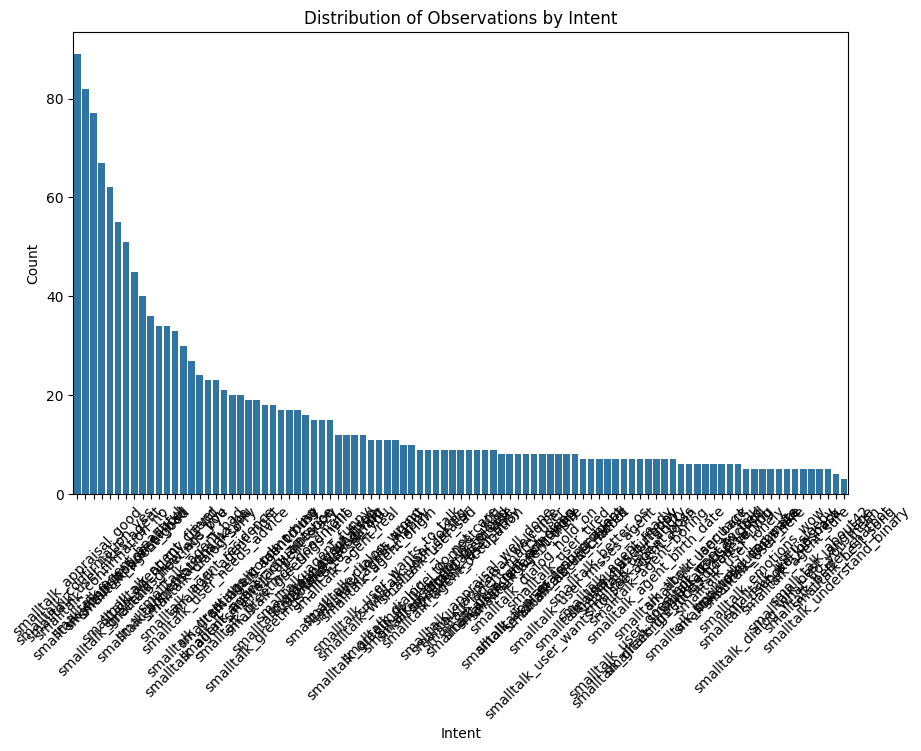

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame

# How many observations does the dataset contain?
num_observations = len(df)
print(f"Number of observations: {num_observations}")

# How many different labels does the dataset contain?
num_labels = df['intent'].nunique()
print(f"Number of different labels: {num_labels}")

# Which labels contain the most observations?
label_counts = df['intent'].value_counts()
most_common_label = label_counts.idxmax()
most_common_count = label_counts.max()
print(f"Label with the most observations: {most_common_label} (Count: {most_common_count})")

# Which labels contain the fewest observations?
least_common_label = label_counts.idxmin()
least_common_count = label_counts.min()
print(f"Label with the fewest observations: {least_common_label} (Count: {least_common_count})")

# Labels with only one observation (not overlapping)
unique_labels = label_counts[label_counts == 1].index.tolist()
print(f"Labels with only one observation (not overlapping): {unique_labels}")

# Visualization: Bar plot of label counts
plt.figure(figsize=(10, 6))
sns.countplot(x='intent', data=df, order=label_counts.index)
plt.title('Distribution of Observations by Intent')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## It's time to clean up !


Not all NLP tasks require the same preprocessing. In this case, we have to ask ourselves some questions: 

- Are there unwanted characters in the dataset? For example, do you want to keep the smiley's or not?  
  - If, for example, you want to create labels to analyze feelings, it might be perishable to keep the smiley's.
- Is it relevant to keep capital letters in sentences?
  - In this case, capital letters don't really matter, because on one hand, not everyone starts their sentences with capital letters when chatting. On the other hand, the sentences are quite short, addressed directly to Odile. 
- Is it necessary to limit the number of characters in a sentence?
  - Again in this case it may be preferable to limit the number of words. The questions asked to Odile are supposed to be short, as too long sentences could interfere with the classification if they contain too much information.

There is no universal answer. Everything will depend on the expected result. 

**Exercise :** Clean the dataset.
- Remove all unnecessary characters. You can choose to keep the smiley's or not.
- Put all sentences in lower case.
- Limit text to 256 words.

What other preprocessing steps can you think of?

In [7]:
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize

def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-zA-Z\'\-]", " ", text) 
  return " ".join(word_tokenize(text)[:256])

df["clean_sentence"] = df.sentence.apply(clean_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\becode\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentence,intent,clean_sentence
0,who are you?,smalltalk_agent_acquaintance,who are you
1,all about you,smalltalk_agent_acquaintance,all about you
2,what is your personality,smalltalk_agent_acquaintance,what is your personality
3,define yourself,smalltalk_agent_acquaintance,define yourself
4,what are you,smalltalk_agent_acquaintance,what are you


## Defining observations (`X`) and labels (`y`)

As you know, training a model requires a set of observations (`X`) and their corresponding labels (`y`).

In that case, `X` is your clean text and `y` is the intent.

Do not forget that we are dealing with a multi-class classification problem. Then, you may have to **one-hot encode** the target value. Keep track of the mapping between the one-hot encoding and the labels in a dictionary.

In [8]:
X = df["clean_sentence"].tolist()
y = pd.get_dummies(df['intent'])

mapping = {i: name for i, name in enumerate(y.columns)}

## Split your dataset!

After all this time, I dare to hope that it is not necessary to explain this step anymore!

**Exercise :** Create the variables `X_train`, `X_val`, `X_test`, `y_train`, `y_val` and `y_test`. 

In [9]:
from sklearn.model_selection import train_test_split
# Split Train and Validation data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

## Tokenization 
If you don't know what tokenization is anymore: look [here](../1.preprocessing/1.tokenization.ipynb).

We will use the tokenizer provided by BERT. This is a pre-trained model that will save us time. 

**Exercise :** Create a `tokenizer` variable and instantiate `DistilBertTokenizer.from_pretrained()` from `transformers`. You have to load `distilbert-base-uncased` model. (Uncased for case-insensitive.) 

Read more: [Tokenizer documentation](https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertTokenizer).

In [10]:
import tensorflow as tf
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

c:\Users\becode\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<?, ?B/s]
c:\Users\becode\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\becode\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows

### Tokenize the dataset

Good! We have instantiated our tokenizer but we have not yet encoded our words in vector.
To do this we will have to apply the tokenizer on our dataset. This will convert our texts into vectors.


**Exercise:** Create the `train_encodings`, `val_encodings` and `test_encodings` by calling the tokenizer on `X_train`,  `X_val` and `X_test`.

You need to know 3 parameters. 

- **max_length:** Maximum length of the sequence. You can set it to 200
- **truncation:** This will truncate to a maximum length specified by the max_length argument. This will truncate token by token, removing a token from the longest sequence in the pair until the proper length is reached. You can set it to `True`
- **padding:** this is the parameter to make all vectors have the same length. You can set it to `True`.

[More info here](https://huggingface.co/docs/transformers/preprocessing)

In [11]:
train_encodings = tokenizer(X_train, max_length=200, truncation=True, padding=True)
val_encodings = tokenizer(X_val, max_length=200, truncation=True, padding=True)
test_encodings = tokenizer(X_test, max_length=200, truncation=True, padding=True)

## Prepare the datasets for training

You can now convert your training, evaluation and test sets in a dataset that will contain both observations and labels. Use the [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) method from Tensorflow to create the datasets. This methods takes two arguments:

*   The encodings that you have just created (casted as a `dict`)
*   The labels



In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

## Training

### Load BERT model

You will need to load the BERT pre-trained model by using the class `TFDistilBertForSequenceClassification`

⚠️ You must use the same model as the one used for tokenization. So in our case  `distilbert-base-uncased`. 

* [BERT for Sequence Classification Documentation](https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertForSequenceClassification)

**Exercise:** Create a model variable and load it by using  `TFDistilBertForSequenceClassification.from_pretrained()` As a parameter, you must indicate the number of labels (get this number from your original dataframe).


In [13]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(set(y)))

model.safetensors: 100%|██████████| 268M/268M [00:24<00:00, 10.9MB/s] 
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pr

### Training arguments

Let's define the the training arguments and compile our model

*   Define the optimizer (Adam) and its learning rate
*   Define the loss function that will be used (remember that we have one-hot encoded output data)
*   Define the evaluation appropriate metrics
*   Compile the model with the right metrics
*   Display the model summary

In [14]:
OPTIMIZER =  tf.keras.optimizers.Adam(learning_rate=3e-5)
LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
METRICS = ['accuracy']

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
model.summary()


Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  73055     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 67026527 (255.69 MB)
Trainable params: 67026527 (255.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

Define first the number of epochs and the batch size for the training.

The batch size will depend on your machine. If you have a weak GPU, I advise you to put 8 or 16.

The number of epochs will depend on your machine, the batch size, etc...You can start with 5 for example

In [11]:
BATCH_SIZE = 8
EPOCHS = 5

In [12]:
history = model.fit(
    train_dataset.batch(BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_dataset.batch(BATCH_SIZE)
)

Epoch 1/5
136/136 [==============================] - 263s 2s/step - loss: 4.1420 - accuracy: 0.1461 - val_loss: 3.5880 - val_accuracy: 0.3233
Epoch 2/5
136/136 [==============================] - 231s 2s/step - loss: 2.9649 - accuracy: 0.4688 - val_loss: 2.5738 - val_accuracy: 0.5675
Epoch 3/5
136/136 [==============================] - 227s 2s/step - loss: 2.0150 - accuracy: 0.6994 - val_loss: 1.8948 - val_accuracy: 0.6831
Epoch 4/5
136/136 [==============================] - 240s 2s/step - loss: 1.4025 - accuracy: 0.8042 - val_loss: 1.4614 - val_accuracy: 0.7302
Epoch 5/5
136/136 [==============================] - 242s 2s/step - loss: 0.9784 - accuracy: 0.8824 - val_loss: 1.1718 - val_accuracy: 0.7901


### Plot the learning curve of your model

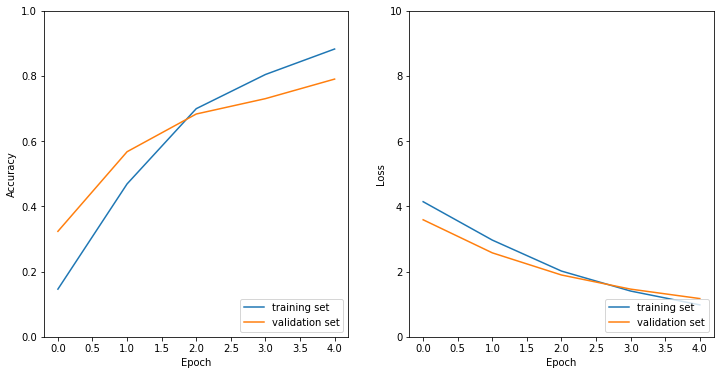

In [13]:
import tensorflow
from matplotlib import pyplot as plt

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

## Model Evaluation

We can now evaluate our model on the test set. Use the `model.evaluate()` function.

In [14]:
loss, accuracy = model.evaluate(test_dataset.batch(BATCH_SIZE))
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

39/39 [==============================] - 15s 386ms/step - loss: 1.2293 - accuracy: 0.7685
Loss: 1.229284644126892
Accuracy: 0.7684887647628784


**Exercise:** is the accuracy the best metrics for this dataset ? Explain your answer !

## Test your model

Well done, you did it :-)

Oh...I have an idea ! Try to classify the sentence *Well done !* with your model

Think to apply all the preprocessing steps and predict the intent of the user.

**Tip:** use the mapping you have created above to retrieve the original label of the prediction !

In [16]:
text = "Well done !"
text = clean_text(text)
encodings = tokenizer([text], max_length=200, truncation=True, padding=True)
ds = tf.data.Dataset.from_tensor_slices(dict(encodings))
predictions = model.predict(ds)

import numpy as np
print(mapping[np.argmax(predictions[0])])



smalltalk_appraisal_well_done
